# Text Mining - Análise de Sentimentos dos Reviews da Amazon
### René Porto e Ricardo Rolim

### Importar ficheiros

In [409]:
import os
import pandas as pd
import numpy as np
import nltk
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from nltk.probability import FreqDist
from textblob import TextBlob

# preciso destas duas linhas
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /home/a101597/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [168]:
df = pd.read_csv("../TM/data/en-sentiment/amazon_reviews_train.csv", encoding="utf-8")
df_test = pd.read_csv("../TM/data/en-sentiment/amazon_reviews_test.csv", encoding="utf-8")
df.sample(5)

,sentiment,review
4069,positive,"Very crunchy and salty, just like described. I..."
11454,positive,This is fabulous and it's what we drank when t...
18518,positive,"These are great, long-lasting chews for small ..."
30622,positive,"Good spice blend. However, I was very dissapo..."
16732,positive,Hickory Smoked Primal Jerky is awesome! Jerky ...


### Funções

In [169]:
# https://medium.com/@jorlugaqui/how-to-strip-html-tags-from-a-string-in-python-7cb81a2bbf44

def remover_tag_html(text):
    """
    Function that removes html tags
    Arguments:
        a: text
    Return:
        text without html tags
    """
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [170]:
def plot_Cloud(wordCloud, name):
    """
    Function that creates word cloud
    Arguments:
        a: text
    Return:
        image with word cloud
    """
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordCloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    name = name + ".png"
    plt.savefig(name, facecolor='k', bbox_inches='tight')

In [171]:
def stemming(tokens):
    """
    Function that stemms tokens
    Arguments:
        tokens: list of tokens
    Return:
        stemmed words
    """
    ps=PorterStemmer()
    stem_words=[]
    for x in tokens:
        stem_words.append(ps.stem(x))
    return stem_words

In [172]:
# Não estamos usando

def lemmatizer(tokens):
    """
    Function that lemma tokens
    Arguments:
        tokens: list of tokens
    Return:
        lemmed words
    """
    lemmatizer = WordNetLemmatizer()
    lem_words=[]
    for x in tokens:
        lem_words.append(lemmatizer.lemmatize(x))
    return lem_words

In [173]:
def summary_dataset(df, df_test):
    """
    Function that returns a summary of a dataset
    Arguments:
        df: train dataset
        df_test: test dataset
    Return:
        summary of train and test dataset
    """
    count_pos_train = df.loc[df.sentiment=='positive', 'sentiment'].count()
    count_neg_train = df.loc[df.sentiment=='negative', 'sentiment'].count()
    count_pos_test = df_test.loc[df_test.sentiment=='positive', 'sentiment'].count()
    count_neg_test = df_test.loc[df_test.sentiment=='negative', 'sentiment'].count()
    total_train = len(df)
    total_test = len(df_test)
    total = total_train + total_test
    print(f"Treino (positivo): {count_pos_train} - {round(100 * count_pos_train / total_train,2)}% \
          \nTreino (negativo): {count_neg_train} - {round(100 * count_neg_train / total_train,2)}% \
          \nTotal Treino: {total_train} - {round(100 * total_train / total,2)}% \
          \n \
          \nTeste (positivo): {count_pos_test} - {round(100 * count_pos_test / total_test,2)}% \
          \nTeste (negativo): {count_neg_test} - {round(100 * count_neg_test / total_test,2)}% \
          \nTotal Teste: {total_test} - {round(100 * total_test / total,2)}% \
          \n \
          \nTotal: {total}")

In [174]:
#https://stackoverflow.com/questions/43485469/apply-textblob-in-for-each-row-of-a-dataframe
#https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html

# Decidimos usar o ZERO como review positivo

def sentiment_calc(text):
    """
    Function that returns a binary sentiment calculation using TextBlob
    Arguments:
        text: text
    Return:
        return a binary sentiment (positivo ou negativo)
    """
    try:
        sentiment_binary = TextBlob(text).sentiment.polarity
        return sentiment_binary
    except:
        return None

In [344]:
def sentiment_convert(df, column, convert):
    """
    Function that returns a binary sentiment
    Arguments:
        sentiment: sentiment (positivo ou negativo)
    Return:
        return a binary sentiment number (positivo = 1 ou negativo = 0)
    """
    label = []
    if convert == 0:
        for each in df[column]:
            if each == 'positive':
                label.append(1)
            else:
                label.append(0)
    elif convert == 1:
        for each in df[column]:
            if each == 1:
                label.append('positive')
            else:
                label.append('negative')
    elif convert == 2:
        for each in df[column]:
            if each >= 0:
                label.append('positive')
            else:
                label.append('negative')
    else:
        for each in df[column]:
            if each >= 0:
                label.append(1)
            else:
                label.append(0)
    return label

In [176]:
def create_bag_Word_Corpus(df, column_name, neg):
    """
    Function that creates a bag of words, remove html tags, lower case words, tokenize, 
    remove stop words, stemming, apply negation (optional) and remove punctuation.
    Arguments:
        df: dataframe
        column_name: column to create cleaned bag of words
        neg: create a lexo negation (optinal)
    Return:
        return bag of words
    """
    negation = ["not", "n't"]
    words_corpus  = []
    for val in df[column_name]:
        sk = False
        text = remover_tag_html(val)
        text = text.lower()
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in stopwords.words('english')]
        tokens = stemming(tokens)
        if neg is True:
            for x, i in enumerate(tokens):
                if i in negation:
                    sk = True
                elif i in string.punctuation:
                    sk = False
                elif sk is True:
                    tokens[x] = "NOT_"+i
        tokens = [word for word in tokens if word not in string.punctuation]
        words_corpus.append(tokens)
    return words_corpus

In [177]:
def sentiment_lex(df, column_name):
    """
    Function that returns a sentiment from a lexo file
    Arguments:
        df: dataframe
        column_name: column to create cleaned bag of words
    Return:
        return a binary sentiment (positivo ou negativo)
    """
    sentiment_lex = []
    for tokens in df[column_name]:
        sentiment_score = sum(lex[x] for x in tokens if x in lex)
        result = 'positive' if sentiment_score >= 0 else 'negative'
        sentiment_lex.append(result)
    return sentiment_lex

In [213]:
#https://medium.com/analytics-vidhya/sentiment-analysis-movies-reviews-b299de4bb1aa

def plot_confusion_matrix_accurancy(df, col_pred, col_actual):
    """
    Function that returns a confusion matrix and accurancy
    Arguments:
        col_pred: column that are inserted our prediction
        col_actual: label
    Return:
        return a binary sentiment (positivo ou negativo)
    """
    cm = confusion_matrix(df[col_pred], df[col_actual], labels=['positive', 'negative'])
    plt.figure(figsize = (5,5))
    sns.heatmap(cm,cmap= "Blues", 
                linecolor = 'black', 
                linewidth = 1, 
                annot = True, 
                fmt='', 
                xticklabels = ['Negative','Positive'], 
                yticklabels = ['Negative','Positive'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    score = accuracy_score(df[col_pred], df[col_actual])
    return print("accuracy:   %0.3f" % score)

In [179]:
#https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.Yj-znufP2Mo

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

#transform no consjunto de teste
def tfidf_fit(df, column):
    """
    Function that returns TF-IDF
    Arguments:
        df: dataframe
        column_name: column to calculate TF-IDF
    Return:
        return TF-IDF
    """
    tfidf_vectorizer=TfidfVectorizer(use_idf=True)
    tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(df[column]) 
    return tfidf_vectorizer_vectors

In [180]:
#https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.Yj-znufP2Mo

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

#transform no consjunto de teste
def tfidf_transform(df, column):
    """
    Function that returns TF-IDF
    Arguments:
        df: dataframe
        column_name: column to calculate TF-IDF
    Return:
        return TF-IDF
    """
    tfidf_vectorizer=TfidfVectorizer(use_idf=True)
    tfidf_vectorizer_vectors=tfidf_vectorizer.transform(df[column]) 
    return tfidf_vectorizer_vectors

In [181]:
def report_model(df, column, y_pred):
    """
    Function that report metrics of a model
    Arguments:
        df: dataframe
        column_name: column to calculate TF-IDF
        y_pred: prediction column
    Return:
        return report metrics of a model
    """
    print("Pontos rotulados incorretamente: %d de %d"% ((df[column]!=y_pred).sum(), df.shape[0]))
    print("Accuracy: ", metrics.accuracy_score(df[column], y_pred))
    print("Precision: ", metrics.precision_score(df[column], y_pred, average="macro"))
    print("Recall: ", metrics.recall_score(df[column], y_pred, average="macro"))
    print("F1-measure: ", metrics.f1_score(df[column], y_pred, average="macro"))

### Análise Exploratória dos Dados

In [188]:
print(f"Valores de treino duplicados: {df.duplicated().sum()} ")
print(f"Valores de teste duplicados: {df_test.duplicated().sum()} ")

Valores de treino duplicados: 3531 
Valores de teste duplicados: 25 


In [189]:
summary_dataset(df, df_test)

Treino (positivo): 37835 - 77.37%           
Treino (negativo): 11067 - 22.63%           
Total Treino: 48902 - 95.29%           
           
Teste (positivo): 1676 - 69.34%           
Teste (negativo): 741 - 30.66%           
Total Teste: 2417 - 4.71%           
           
Total: 51319


In [190]:
df = df.drop_duplicates()
df_test = df_test.drop_duplicates()
summary_dataset(df, df_test)

Treino (positivo): 35363 - 77.94%           
Treino (negativo): 10008 - 22.06%           
Total Treino: 45371 - 94.99%           
           
Teste (positivo): 1667 - 69.69%           
Teste (negativo): 725 - 30.31%           
Total Teste: 2392 - 5.01%           
           
Total: 47763


Foram encontrados registos duplicados, como a proporção entre os reviews positivos e negativos não se alteraram, decidimos então remover os registos duplicados

### Baseline

In [345]:
df['sentiment_calculated'] = df['review'].apply(sentiment_calc)

In [346]:
df.sample(5)

,sentiment,review,sentiment_calculated,bag,bag_neg,sentiment_lex,sentiment_lex_neg,sentiment_to_binary_n
6806,positive,This cereal is good and will get you full and ...,positive,"[cereal, good, get, full, satiat, best, mix, l...","[cereal, good, get, full, satiat, best, mix, l...",positive,positive,1.0
29828,negative,The Gold Kili flavor is very powerful raw ging...,positive,"[gold, kili, flavor, power, raw, ginger, littl...","[gold, kili, flavor, power, raw, ginger, littl...",positive,positive,0.0
19617,positive,This bread is super-easy to make in a bread ma...,positive,"[bread, super-easi, make, bread, machin, tast,...","[bread, super-easi, make, bread, machin, tast,...",positive,positive,1.0
1530,positive,Sweetarts evokes nostalgic memories of going i...,negative,"[sweetart, evok, nostalg, memori, go, candi, s...","[sweetart, evok, nostalg, memori, go, candi, s...",positive,positive,1.0
3197,positive,I bought this kit and I have to say that it wa...,positive,"[bought, kit, say, hit, origin, bought, wife, ...","[bought, kit, say, hit, origin, bought, wife, ...",positive,positive,1.0


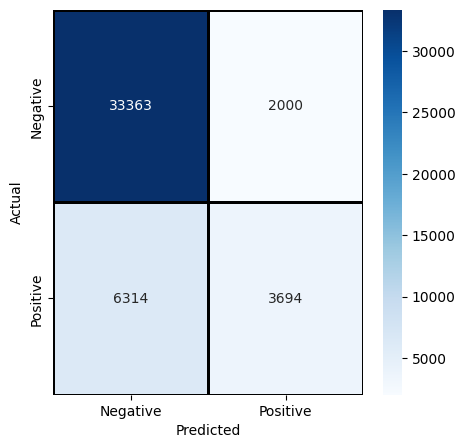

accuracy:   0.817


In [106]:
plot_confusion_matrix_accurancy(df, 'sentiment', 'sentiment_calculated')

### Aplicação de um léxico de sentimentos

In [192]:
lex = pd.read_csv("../TM/data/en/NCR-lexicon.csv", encoding="utf-8")
lex.set_index("English", inplace=True)
lex = lex['Positive'] - lex['Negative']
lex = lex.to_dict()

In [193]:
df['bag'] = create_bag_Word_Corpus(df, 'review', neg=False)
df['bag_neg'] = create_bag_Word_Corpus(df, 'review', neg=True)
df['sentiment_lex'] = sentiment_lex(df, 'bag')
df['sentiment_lex_neg'] = sentiment_lex(df, 'bag_neg')

#### Sem tratamento da negação

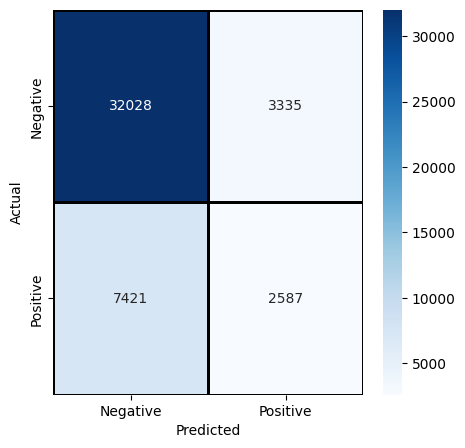

accuracy:   0.763


In [199]:
plot_confusion_matrix_accurancy(df, 'sentiment', 'sentiment_lex')

#### Com tratamento da negação

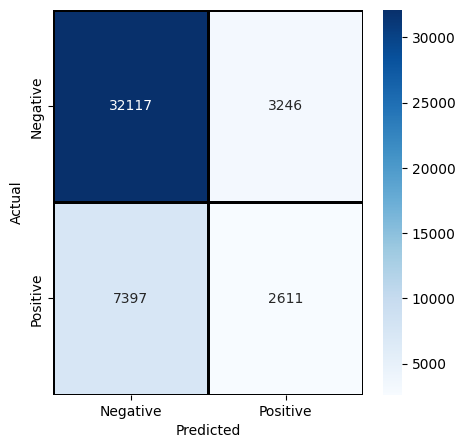

accuracy:   0.765


In [200]:
plot_confusion_matrix_accurancy(df, 'sentiment', 'sentiment_lex_neg')

### Aprendizagem automática

#### Features:

- Maiúsculas e minúsculas
- Minúsculas
- Normalização de palavras
- Steaming
- Com e sem part-of-speach
- Entidades mencionadas
- GloVe (embeddings)

Possible Improvements
* Filtering
* Part of Speech Tag Filter - tirara palavras fechadas
* Chunks (Parsing)
* **NER**

#### Models to test:

- **Logistic Regression**
- **Support Vector Machine (SVM)**
- **Multinomial Naive Bayes**

### Preparação dos Dados

In [358]:
df['label'] = sentiment_convert(df, 'sentiment', convert=0)
df_test['label'] = sentiment_convert(df_test, 'sentiment', convert=0)

In [388]:
df['review'] = df['review'].apply(str)
df_test['review'] = df_test['review'].apply(str)

### Features

In [401]:
vectorizer = CountVectorizer()
train_X = vectorizer.fit_transform(df['review'])
test_X = vectorizer.transform(df_test['review'])

In [390]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
train_tfidf = tfidf_vectorizer.fit_transform(df['review']) 
test_tfidf = tfidf_vectorizer.transform(df_test['review']) 

### Models

#### Multinomial Naive Bayes

In [431]:
nb = MultinomialNB()
Mult_nb = nb.fit(train_X, df['label'])
df_test['sentiment_mnb'] = Mult_nb.predict(test_X)
score_mnb = accuracy_score(df_test['label'], df_test['sentiment_mnb'])
print("MultinomialNB accuracy:   %0.3f" % score_mnb)

MultinomialNB accuracy:   0.854


In [432]:
nb = MultinomialNB()
Mult_nb_tfidf = nb.fit(train_tfidf, df['label'])
df_test['sentiment_mnb_tfidf'] = Mult_nb_tfidf.predict(test_tfidf)
score_tfidf_mnb = accuracy_score(df_test['label'], df_test['sentiment_mnb_tfidf'])
print("TFIDF-MultinomialNB accuracy:   %0.3f" % score_tfidf_mnb)

TFIDF-MultinomialNB accuracy:   0.708


#### Logistic_regression

In [441]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lre = lr.fit(train_X, df['label'])
df_test['sentiment_lr'] = lre.predict(test_X)
score_lre = accuracy_score(df_test['label'], df_test['sentiment_lr'])
print("Lr accuracy:   %0.3f" % score_lre)

Lr accuracy:   0.866


In [442]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lre_tfidf = lr.fit(train_tfidf, df['label'])
df_test['sentiment_lr_tfidf'] = lre_tfidf.predict(test_tfidf)
score_tfidf_lre = accuracy_score(df_test['label'], df_test['sentiment_lr_tfidf'])
print("TFIDF-Lr accuracy:   %0.3f" % score_tfidf_lre)

TFIDF-Lr accuracy:   0.855


#### Linear SVC

In [458]:
svmc = LinearSVC(max_iter=20000)
lsvm = svmc.fit(train_X, df['label'])
df_test['sentiment_lsvm'] = lsvm.predict(test_X)
score_lsvm = accuracy_score(df_test['label'], df_test['sentiment_lsvm'])
print("lsvm accuracy:   %0.3f" % score_lsvm)

lsvm accuracy:   0.841


In [459]:
svmc = LinearSVC(max_iter=20000)
lsvm_tfidf = svmc.fit(train_tfidf, df['label'])
df_test['sentiment_lsvm_tfidf'] = lsvm_tfidf.predict(test_tfidf)
score_tfidf_lsvm = accuracy_score(df_test['label'], df_test['sentiment_lsvm_tfidf'])
print("TFIDF-lsvm accuracy:   %0.3f" % score_tfidf_lsvm)

TFIDF-lsvm accuracy:   0.868
